In [1]:
from sklearn.datasets import load_files  
import numpy as np
from keras.utils import np_utils

In [2]:
def load_dataset(path):
    data = load_files(path)
    mask_files = np.array(data['filenames'])
    mask_targets = np_utils.to_categorical(np.array(data['target']),4)
    class_names = data['target_names']
    return mask_files, mask_targets, class_names

# load train, test, and validation datasets
train_files, train_targets, class_names = load_dataset('../input/face-mask-classification/Train')
valid_files, valid_targets, _ = load_dataset('../input/face-mask-classification/Validation')
test_files, test_targets, _ = load_dataset('../input/face-mask-classification/Test')

In [3]:
import cv2
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.xception import preprocess_input

def load_image(path):
    image = cv2.imread(path).astype(np.float32)
    image_resized = cv2.resize(image,(250,250))
    image/=255.0
    image = preprocess_input(image_resized)
    return image

def load_dataset(files):
    for i, file in enumerate(files):
        vector = []
        for file in files:
            vector.append(load_image(file))
        return np.array(vector)


train_X = load_dataset(train_files)
test_X = load_dataset(test_files)
val_test_X = load_dataset(valid_files)

In [4]:
print(train_X.shape)
print(val_test_X.shape)
print(train_targets.shape)
print(valid_targets.shape)

(2354, 250, 250, 3)
(292, 250, 250, 3)
(2354, 4)
(292, 4)


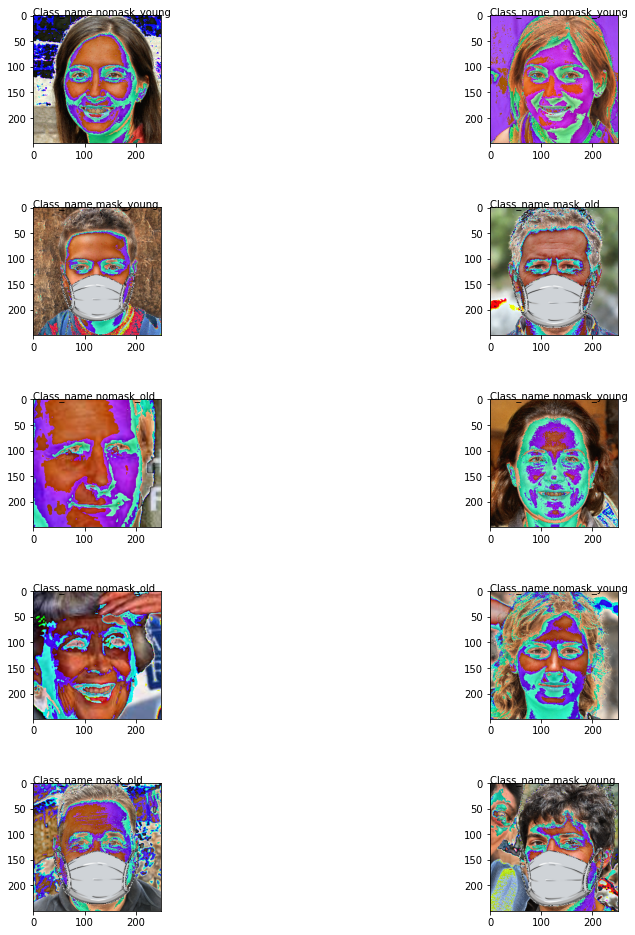

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,20))
fig.subplots_adjust(hspace=0.5)
rows = 6
columns = 2
for i in range(10):
    ax1 = fig.add_subplot(rows, columns,(i+1))
    ax1.imshow(cv2.cvtColor((train_X[i]*255).astype('uint8'), cv2.COLOR_BGR2RGB ))
    title = ("Class_name "+ class_names[np.argmax(train_targets[i])])
    ax1.text(0, -2, title, size=10)
plt.show()

In [6]:
Number_of_Clases = 4


In [7]:
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

In [8]:
model = Xception(include_top=False, input_shape=(250,250,3), weights="imagenet")

layer = model.get_layer('block13_pool')

flat = Flatten()(layer.output)
class_ = Dense(1024, activation='relu')(flat)
outputs = Dense(4, activation='softmax')(class_)

model = Model(inputs=model.inputs, outputs = outputs)

model.summary()

2022-04-20 11:46:13.602540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 11:46:13.748472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 11:46:13.749526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 11:46:13.751242: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 124, 124, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 124, 124, 32) 0           block1_conv1_bn[0][0]            
_____________________________

In [9]:
import keras
import tensorflow as tf 
from tensorflow import keras

optimizer = keras.optimizers.Adamax(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [10]:
#Image augmentation
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=10,
		zoom_range=0.2,
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.2,
		horizontal_flip=True,
		fill_mode="nearest"
        )

datagen.fit(train_X)

#Save best model
checkpoint = ModelCheckpoint('best_model.pt', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit_generator(datagen.flow(train_X, 
                                 train_targets,
                                 batch_size=32),
                    epochs=100,
                    callbacks=[checkpoint],
                    validation_data=(val_test_X, 
                                     valid_targets))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-04-20 11:46:20.953661: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-04-20 11:46:27.220556: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


74/74 [==============================] - 60s 642ms/step - loss: 1.6414 - accuracy: 0.8407 - val_loss: 1.6957 - val_accuracy: 0.6575

Epoch 00001: val_accuracy improved from -inf to 0.65753, saving model to best_model.pt


2022-04-20 11:47:31.123835: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
74/74 [==============================] - 48s 640ms/step - loss: 0.1441 - accuracy: 0.9494 - val_loss: 0.4527 - val_accuracy: 0.8459

Epoch 00002: val_accuracy improved from 0.65753 to 0.84589, saving model to best_model.pt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/100
74/74 [==============================] - 47s 626ms/step - loss: 0.1412 - accuracy: 0.9507 - val_loss: 0.2176 - val_accuracy: 0.9075

Epoch 00003: val_accuracy improved from 0.84589 to 0.90753, saving model to best_model.pt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/100
74/74 [==============================] - 47s 628ms/step - loss: 0.0980 - accuracy: 0.9660 - val_loss: 0.2014 - val_accuracy: 0.9247

Epoch 00004: val_accuracy improved from 0.90753 to 0.92466, saving model to best_model.pt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/100
74/74 [==============================] - 46s 621ms/step - loss: 0.1034 - accuracy: 0.9601 - val_loss: 0.2008 - val_accuracy: 0.9144

Epoch 00005: val_accuracy did not improve from 0.92466
Epoch 6/100
74/74 [==============================] - 46s 621ms/step - loss: 0.0767 - accuracy: 0.9711 - val_loss: 0.1784 - val_accuracy: 0.9384

Epoch 00006: val_accuracy improved from 0.92466 to 0.93836, saving model to best_model.pt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/100
74/74 [==============================] - 47s 629ms/step - loss: 0.0783 - accuracy: 0.9703 - val_loss: 0.2295 - val_accuracy: 0.9384

Epoch 00007: val_accuracy did not improve from 0.93836
Epoch 8/100
74/74 [==============================] - 46s 620ms/step - loss: 0.0770 - accuracy: 0.9711 - val_loss: 0.1986 - val_accuracy: 0.9418

Epoch 00008: val_accuracy improved from 0.93836 to 0.94178, saving model to best_model.pt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/100
74/74 [==============================] - 47s 628ms/step - loss: 0.0527 - accuracy: 0.9796 - val_loss: 0.2036 - val_accuracy: 0.9384

Epoch 00009: val_accuracy did not improve from 0.94178
Epoch 10/100
74/74 [==============================] - 46s 624ms/step - loss: 0.0493 - accuracy: 0.9834 - val_loss: 0.2114 - val_accuracy: 0.9486

Epoch 00010: val_accuracy improved from 0.94178 to 0.94863, saving model to best_model.pt


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/100
74/74 [==============================] - 47s 625ms/step - loss: 0.0492 - accuracy: 0.9783 - val_loss: 0.2035 - val_accuracy: 0.9452

Epoch 00011: val_accuracy did not improve from 0.94863
Epoch 12/100
74/74 [==============================] - 47s 633ms/step - loss: 0.0383 - accuracy: 0.9856 - val_loss: 0.2252 - val_accuracy: 0.9486

Epoch 00012: val_accuracy did not improve from 0.94863
Epoch 13/100
74/74 [==============================] - 46s 616ms/step - loss: 0.0337 - accuracy: 0.9860 - val_loss: 0.2394 - val_accuracy: 0.9384

Epoch 00013: val_accuracy did not improve from 0.94863
Epoch 14/100
74/74 [==============================] - 47s 636ms/step - loss: 0.0371 - accuracy: 0.9881 - val_loss: 0.2766 - val_accuracy: 0.9452

Epoch 00014: val_accuracy did not improve from 0.94863
Epoch 15/100
74/74 [==============================] - 46s 620ms/step - loss: 0.0325 - accuracy: 0.9885 - val_loss: 0.2397 - val_accuracy: 0.9486

Epoch 00015: val_accuracy did not improve from 0.9

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/100
74/74 [==============================] - 48s 634ms/step - loss: 0.0337 - accuracy: 0.9885 - val_loss: 0.2844 - val_accuracy: 0.9521

Epoch 00018: val_accuracy did not improve from 0.95205
Epoch 19/100
74/74 [==============================] - 47s 636ms/step - loss: 0.0265 - accuracy: 0.9907 - val_loss: 0.3007 - val_accuracy: 0.9418

Epoch 00019: val_accuracy did not improve from 0.95205
Epoch 20/100
74/74 [==============================] - 47s 633ms/step - loss: 0.0180 - accuracy: 0.9936 - val_loss: 0.2976 - val_accuracy: 0.9486

Epoch 00020: val_accuracy did not improve from 0.95205
Epoch 21/100
74/74 [==============================] - 48s 641ms/step - loss: 0.0282 - accuracy: 0.9919 - val_loss: 0.3161 - val_accuracy: 0.9486

Epoch 00021: val_accuracy did not improve from 0.95205
Epoch 22/100
74/74 [==============================] - 49s 657ms/step - loss: 0.0248 - accuracy: 0.9911 - val_loss: 0.3501 - val_accuracy: 0.9452

Epoch 00022: val_accuracy did not improve from 0.9

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 24/100
74/74 [==============================] - 48s 643ms/step - loss: 0.0158 - accuracy: 0.9953 - val_loss: 0.3312 - val_accuracy: 0.9418

Epoch 00024: val_accuracy did not improve from 0.95548
Epoch 25/100
74/74 [==============================] - 48s 643ms/step - loss: 0.0193 - accuracy: 0.9928 - val_loss: 0.3915 - val_accuracy: 0.9486

Epoch 00025: val_accuracy did not improve from 0.95548
Epoch 26/100
74/74 [==============================] - 48s 647ms/step - loss: 0.0158 - accuracy: 0.9936 - val_loss: 0.4020 - val_accuracy: 0.9418

Epoch 00026: val_accuracy did not improve from 0.95548
Epoch 27/100
74/74 [==============================] - 48s 652ms/step - loss: 0.0135 - accuracy: 0.9958 - val_loss: 0.3984 - val_accuracy: 0.9521

Epoch 00027: val_accuracy did not improve from 0.95548
Epoch 28/100
74/74 [==============================] - 48s 649ms/step - loss: 0.0081 - accuracy: 0.9958 - val_loss: 0.3490 - val_accuracy: 0.9486

Epoch 00028: val_accuracy did not improve from 0.9

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 38/100
74/74 [==============================] - 48s 642ms/step - loss: 0.0079 - accuracy: 0.9970 - val_loss: 0.5359 - val_accuracy: 0.9418

Epoch 00038: val_accuracy did not improve from 0.95890
Epoch 39/100
74/74 [==============================] - 48s 645ms/step - loss: 0.0066 - accuracy: 0.9970 - val_loss: 0.5672 - val_accuracy: 0.9384

Epoch 00039: val_accuracy did not improve from 0.95890
Epoch 40/100
74/74 [==============================] - 48s 640ms/step - loss: 0.0125 - accuracy: 0.9945 - val_loss: 0.4758 - val_accuracy: 0.9555

Epoch 00040: val_accuracy did not improve from 0.95890
Epoch 41/100
74/74 [==============================] - 48s 639ms/step - loss: 0.0081 - accuracy: 0.9958 - val_loss: 0.5622 - val_accuracy: 0.9418

Epoch 00041: val_accuracy did not improve from 0.95890
Epoch 42/100
74/74 [==============================] - 49s 656ms/step - loss: 0.0122 - accuracy: 0.9970 - val_loss: 0.5542 - val_accuracy: 0.9384

Epoch 00042: val_accuracy did not improve from 0.9

In [11]:
from keras.models import load_model
model.load_weights('best_model.pt')

2022-04-20 13:16:19.091634: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open best_model.pt: Failed precondition: best_model.pt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [12]:
score = model.evaluate(val_test_X, valid_targets)

print('Test accuracy: ', score[1])

10/10 [==============================] - 1s 87ms/step - loss: 0.4807 - accuracy: 0.9589
Test accuracy:  0.9589040875434875


In [13]:
def get_prediction(image):
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    return class_names[predicted_class]

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
scores = model.evaluate(test_X, test_targets, verbose=0)
print('Accuracy: %.2f%%' % (scores[1]*100))
y_pred = model.predict(test_X)

Accuracy: 94.97%


In [15]:
print(classification_report(y_pred.round(), test_targets))
accuracy = accuracy_score(test_targets, y_pred.round(), normalize=True)
f1score = f1_score(test_targets, y_pred.round(), average='weighted')

              precision    recall  f1-score   support

           0       0.87      0.97      0.92        63
           1       0.97      0.89      0.93        85
           2       0.96      0.99      0.97        71
           3       0.99      0.96      0.97        79

   micro avg       0.95      0.95      0.95       298
   macro avg       0.95      0.95      0.95       298
weighted avg       0.95      0.95      0.95       298
 samples avg       0.95      0.95      0.95       298



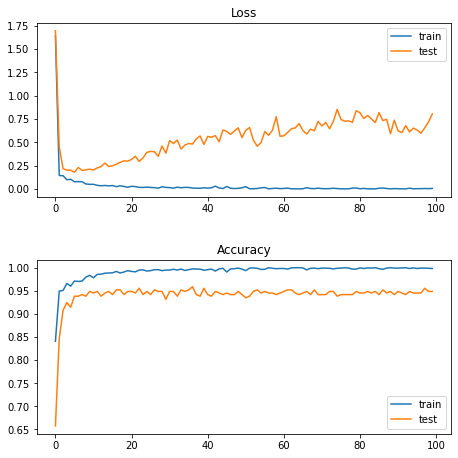

In [16]:
figure, axes = plt.subplots(nrows=2, ncols=1,figsize=(7,7))
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
figure.tight_layout(pad=3.0)
plt.show()

In [17]:
import matplotlib.pyplot as plt
import urllib.request
import cv2

def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_preprocessed  = cv2.resize(image, (250,250))
  image_preprocessed = preprocess_input(image_preprocessed)
  return image_preprocessed, image

def predict_url(url):
  image_preprocessed, image = url_to_image(url)
  predicted_class = get_prediction(image_preprocessed)
  plt.imshow(image)
  plt.title("Предвидено : " + predicted_class)

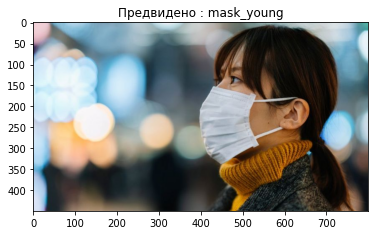

In [18]:
predict_url("https://ichef.bbci.co.uk/news/800/cpsprodpb/E907/production/_110755695_gettyimages-1202072951.jpg")


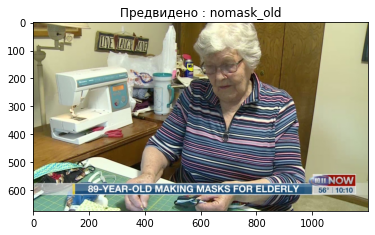

In [19]:
predict_url("https://gray-koln-prod.cdn.arcpublishing.com/resizer/J78VpyO8C969QDLa8cnO3pfeLG8=/1200x675/smart/cloudfront-us-east-1.images.arcpublishing.com/gray/DJ2P5AJ5VRODDDTUBIJMGPJF54.png")


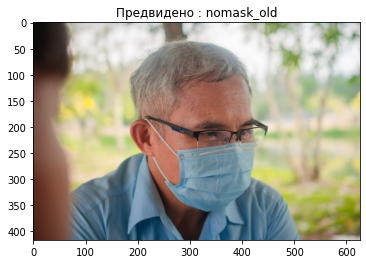

In [20]:
predict_url("https://image.freepik.com/free-photo/old-man-using-face-mask-protect-corona-virus-covid-19-when-communication-with-people_10541-1759.jpg")


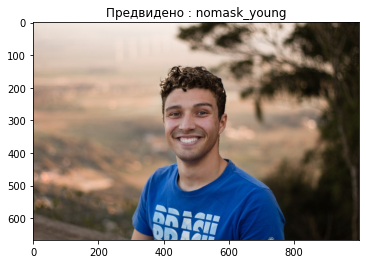

In [21]:
predict_url("https://images.unsplash.com/photo-1536548665027-b96d34a005ae?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&w=1000&q=80")


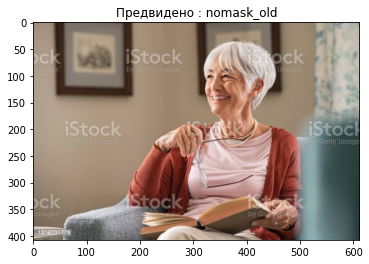

In [22]:
predict_url("https://media.istockphoto.com/photos/happy-senior-woman-smiling-at-home-picture-id1316201778?s=612x612")


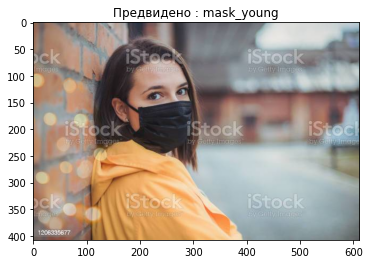

In [23]:
predict_url("https://media.istockphoto.com/photos/air-pollution-in-the-city-picture-id1206335677?s=612x612")


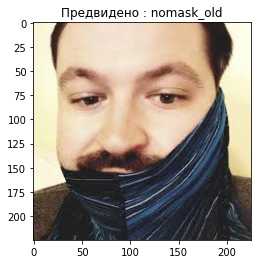

In [24]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRHWmu4DrQdg081nEBO1vsdh_rxU8o9oheXHg&usqp=CAU")


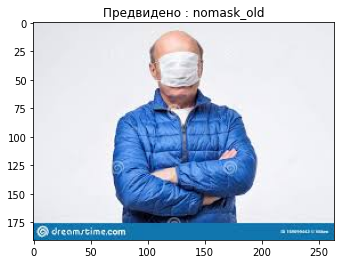

In [25]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRt7p2Fr2Qjm2K44EKaosQQKiP9JQ11__tdfw&usqp=CAU")


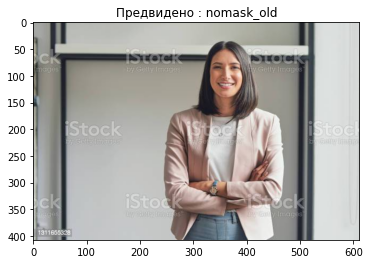

In [26]:
predict_url("https://media.istockphoto.com/photos/m-the-best-asset-in-my-business-picture-id1311655328?s=612x612")

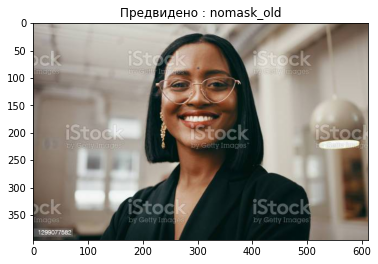

In [27]:
predict_url("https://media.istockphoto.com/photos/positivity-puts-you-in-a-position-of-power-picture-id1299077582?s=612x612")


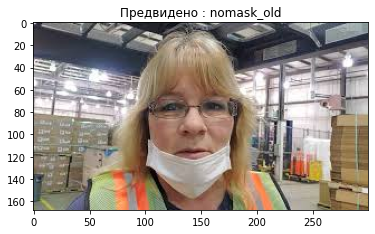

In [28]:
predict_url("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRK9RF4QLN58YrU8p7MIY6Y-hjA8V6ZJ3xktg&usqp=CAU")


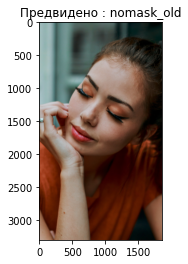

In [29]:
predict_url("https://images.unsplash.com/photo-1587590876124-e11d80c09eec?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1854&q=80")

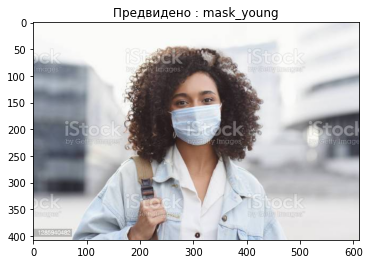

In [30]:
predict_url("https://media.istockphoto.com/photos/young-woman-wearing-protective-face-mask-in-a-city-picture-id1285940482?s=612x612")

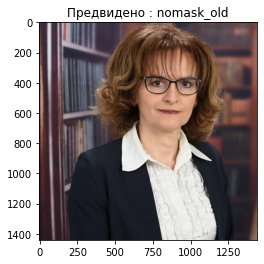

In [31]:
predict_url("https://scontent.fskp4-1.fna.fbcdn.net/v/t1.6435-9/59064647_2704941159522723_6741615177310928896_n.jpg?_nc_cat=104&ccb=1-5&_nc_sid=174925&_nc_ohc=c7o4EnzkGH8AX-vjTvT&tn=ZajtTB348S-4oGOD&_nc_ht=scontent.fskp4-1.fna&oh=00_AT_lmhyvnJ0x-fvXFJzXFoJFIsvMPQGQFDeX6FiQ8rrWPg&oe=62848E7A")

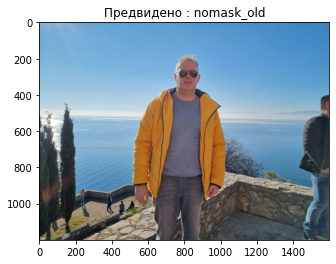

In [32]:
predict_url("https://scontent.fskp4-1.fna.fbcdn.net/v/t39.30808-6/270033485_10223707063617383_1075652749401583653_n.jpg?_nc_cat=102&ccb=1-5&_nc_sid=0debeb&_nc_ohc=ASR3fzsq02cAX_U-FXE&_nc_ht=scontent.fskp4-1.fna&oh=00_AT8hjexvp9CICo5T2sPJPCXBK22TKmBwx7ri1p-ulN_f6g&oe=62659882")

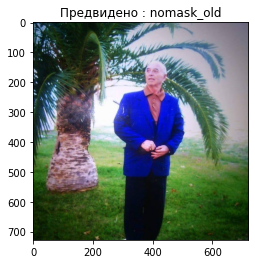

In [33]:
predict_url("https://scontent.fskp4-2.fna.fbcdn.net/v/t1.6435-9/78211653_2174469282849667_1950193754027589632_n.jpg?_nc_cat=108&ccb=1-5&_nc_sid=09cbfe&_nc_ohc=Ljh01Ia1W2gAX_Jsm0p&_nc_oc=AQn3pxue7eKP-r7vb3SE_NaE60ed13lBggpac8r-Pr9zhiQ9WqwEOEDnxxz8XVUg9jw&_nc_ht=scontent.fskp4-2.fna&oh=00_AT9y2NavKVe3IJyJhbDd75wCS5khotf2iWZRhuPwHOMXWA&oe=6286B334")

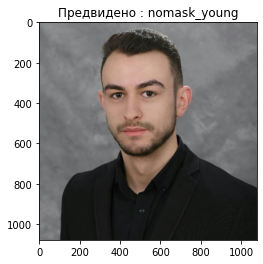

In [34]:
predict_url("https://scontent.fskp4-2.fna.fbcdn.net/v/t31.18172-8/24883622_2114656611894572_5926169380094764908_o.jpg?_nc_cat=108&ccb=1-5&_nc_sid=174925&_nc_ohc=sGSii0z_Qs8AX8yjoFf&_nc_ht=scontent.fskp4-2.fna&oh=00_AT_7grrbhh9gTjuYndq-NsI2Edei4Sdv7PTZloTanNt9Xw&oe=62853667")

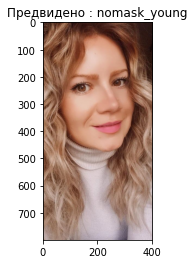

In [35]:
predict_url("https://scontent.fskp4-2.fna.fbcdn.net/v/t39.30808-6/231100922_10225180980540939_7557076079881691171_n.jpg?_nc_cat=109&ccb=1-5&_nc_sid=09cbfe&_nc_ohc=dxffuEeJXc8AX9yJf4j&_nc_ht=scontent.fskp4-2.fna&oh=00_AT855zdQvEL_pGssgk27jX1L1WHMAFNSITgJrNHefEN1Lg&oe=6264C8F8")

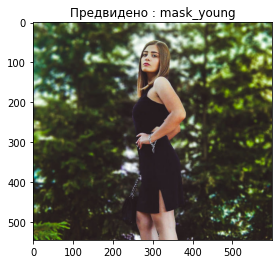

In [36]:
predict_url("https://scontent.fskp4-1.fna.fbcdn.net/v/t1.6435-9/116290080_182023479975779_6014978579436518712_n.jpg?_nc_cat=104&ccb=1-5&_nc_sid=8bfeb9&_nc_ohc=PIalCEL34WoAX-alP3R&_nc_ht=scontent.fskp4-1.fna&oh=00_AT99YhOPRHWH6i8L0Wd0dB1hqGI747oIusVmYmFJJRqgpA&oe=6283C8F6")